In [1]:
import numpy as np
import fixed_income_derivatives as fid
import matplotlib.pyplot as plt
from scipy.stats import gamma
from scipy.optimize import minimize
from scipy.stats import norm
from numpy.polynomial.hermite import hermfit, hermval
import copy

## **Problem 1**

In [2]:
r0, a, b, sigma = 0.032, 1.2, 0.048, 0.1
T_max = 10
alpha = 0.5
M = int(T_max/alpha) + 1
T = np.array([i*alpha for i in range(0,M)])
p = fid.zcb_price_cir(r0,a,b,sigma,T)
R = fid.spot_rate_cir(r0,a,b,sigma,T)
f = fid.forward_rate_cir(r0,a,b,sigma,T)

### *b)* Fitting a CIR model to data

In [3]:
param_0 = 0.03, 0.5, 0.04, 0.08
result = minimize(fid.fit_cir_obj,param_0,method = 'nelder-mead',args = (R,T),options={'xatol': 1e-20,'disp': True})
print(f"Parameters from the fit: {result.x}. SSE of the fit: {result.fun}")

param_0 = 0.03, 0.5, 0.04
result = minimize(fid.fit_cir_no_sigma_obj,param_0,method = 'nelder-mead',args = (sigma,R,T),options={'xatol': 1e-20,'disp': True})
print(f"Parameters from the fit without sigma: {result.x}. SE of the fit: {result.fun}")

Parameters from the fit: [ 0.03200531  1.2087353   0.04785905 -0.03917123]. SSE of the fit: 8.381758974182573e-13
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 234
         Function evaluations: 458
Parameters from the fit without sigma: [0.032 1.2   0.048]. SE of the fit: 2.661042959685261e-29


/var/folders/nd/4k3_lp8n50j_h8d9rbthfry80000gn/T/ipykernel_7235/3931504139.py:2: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(fid.fit_cir_obj,param_0,method = 'nelder-mead',args = (R,T),options={'xatol': 1e-20,'disp': True})


### *c)* Swap rate or forward swap rate


In [4]:
idx_n, idx_N = 0, 20
S_swap = 0
for idx in range(idx_n+1,idx_N+1):
    S_swap += alpha*p[idx]
R_swap = (p[idx_n] - p[idx_N])/S_swap
print(f"Par swap rate: {R_swap}")

# Plotting the spot par swap rate
def swap_fct(idx_n,idx_N,alpha,p):
    S_swap = 0
    for idx in range(idx_n+1,idx_N+1):
        S_swap += alpha*p[idx]
    R_swap = (p[idx_n] - p[idx_N])/S_swap
    return R_swap, S_swap
R_swap_plot = np.zeros([M])
idx_N_plot = np.array([i for i in range(2,M)])
for idx in idx_N_plot:
    R_swap_plot[idx] = swap_fct(0,idx,alpha,p)[0]

Par swap rate: 0.046800678748095556


### *d)* Simulating the short rate in the CIR model


In [5]:
np.random.seed(13)
M_simul, T_simul = 100, 10
size_ci = 0.95
r_simul = fid.short_rate_simul(r0,(a,b,sigma),M_simul,T_simul,method = "cir")
t_simul = np.array([i*(T_simul/M_simul) for i in range(0,M_simul+1)])
lb, ub = fid.ci_cir(r0,a,b,sigma,t_simul,size_ci)
lb_sd, ub_sd = fid.ci_cir(r0,a,b,sigma,100,size_ci)

np.random.seed(1)

### *e)* Computing the price of an interest rate cap in the CIR model


In [6]:
T_cap_begin, T_cap_end = 0.5, 5
strike = 0.045
idx_cap_begin, idx_cap_end = int(T_cap_begin/alpha), int(T_cap_end/alpha)
price_caplet = np.zeros([idx_cap_end+1])
M_simul_cap, N_simul = 500, 2000
chi = np.zeros([idx_cap_end-1,N_simul])
r_simul_cap = np.zeros([M_simul_cap+1])
for i in range(0,N_simul):
    r_simul_cap = fid.short_rate_simul(r0,(a,b,sigma),M_simul_cap,T_cap_end,method = "cir")
    for idx in range(idx_cap_begin,idx_cap_end):
        idx_r_announcement = idx*int((alpha*M_simul_cap)/T_cap_end)
        idx_payment = (idx+1)*int((alpha*M_simul_cap)/T_cap_end)
        p_cap = fid.zcb_price_cir(r_simul_cap[idx_r_announcement],a,b,sigma,alpha)
        delta = (idx+1)*alpha/idx_payment

In [13]:
print(f"idx: {idx}, idx_r_announcement: {idx_r_announcement}, idx_payment: {idx_payment}, delta: {delta}")

idx: 10, idx_r_announcement: 450, idx_payment: 500, delta: 0.01


In [16]:
#chi[idx-1,i] = np.exp(-delta*sum(r_simul_cap[0:idx_payment]))*(1+alpha*strike)*max(1/(1+alpha*strike)-p_cap,0)
for idx in range(idx_cap_begin+1,idx_cap_end+1):
    price_caplet[idx] = sum(chi[idx-2,:])/N_simul
print(f"Caplet prices: {price_caplet*10000},Cap price: {sum(price_caplet)}")

Caplet prices: [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.02267064],Cap price: 2.267064314561751e-06


### *e)* Computing the price of a 2Y3Y swaption


In [17]:
idx_n_swaption, idx_N_swaption = 4, 10
M_simul_swaption, N_simul, T_simul_swaption = 2000, 20000, T[idx_n_swaption]
chi, price_swaption_simul = np.zeros([N_simul]), np.zeros([N_simul])
T_swaption = np.array([T[i] - T[idx_n_swaption] for i in range(idx_n_swaption,idx_N_swaption+1)])
R_swaption = 0.045
for i in range(0,N_simul):
    r_simul_swaption = fid.short_rate_simul(r0,(a,b,sigma),M_simul_swaption,T_simul_swaption,method = "cir")
    p_swaption = fid.zcb_price_cir(r_simul_swaption[-1],a,b,sigma,T_swaption)
    R_swap, S_swap = swap_fct(0,idx_N_swaption-idx_n_swaption,alpha,p_swaption)
    chi[i] = max(R_swap-R_swaption,0)*S_swap
    price_swaption_simul[i] = np.exp(-(T_simul_swaption/M_simul_swaption)*sum(r_simul_swaption))*chi[i]
price_swaption = sum(price_swaption_simul)/N_simul
print(f"price_swaption: {10000*price_swaption}")


price_swaption: 85.92604062233558


### Plotting of zcb prices, spot rates and instantaneous forward rates in the CIR model:

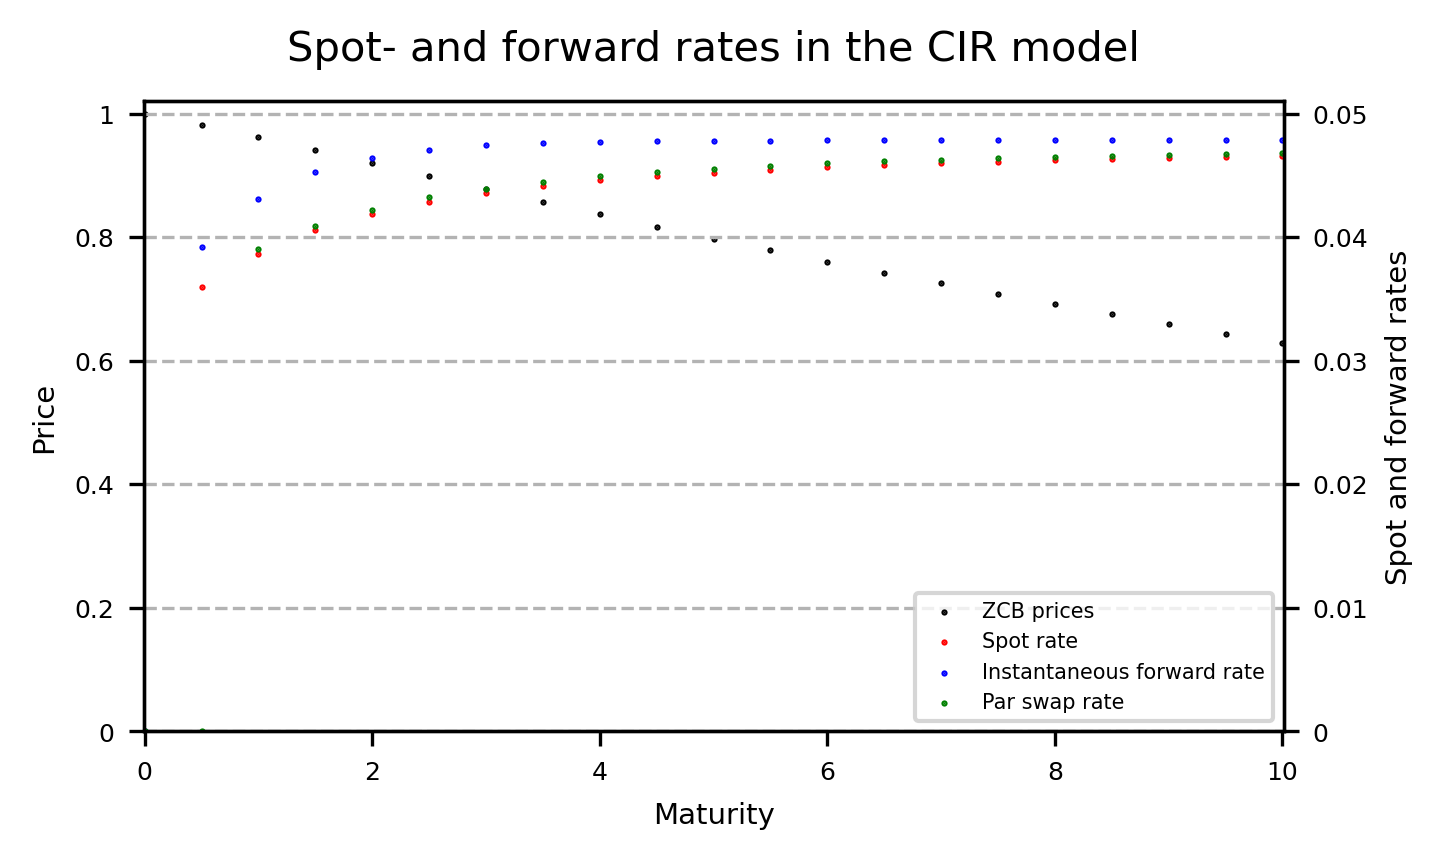

In [20]:
fig = plt.figure(constrained_layout=False,dpi=300,figsize=(5,3))
fig.suptitle(f"Spot- and forward rates in the CIR model",fontsize=10)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
xticks = [0,2,4,6,8,10]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]-0.01,xticks[-1]+0.01])
plt.xlabel(f"Maturity",fontsize = 7)
yticks1 = [0,0.2,0.4,0.6,0.8,1]
ax.set_yticks(yticks1)
ax.set_yticklabels(yticks1,fontsize = 6)
ax.set_ylim([yticks1[0],yticks1[-1] + (yticks1[-1]-yticks1[0])*0.02])
plt.grid(axis = 'y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
ax.set_ylabel(f"Price",fontsize = 7)
p1 = ax.scatter(T, p, s = 1, color = 'black', marker = ".",label="ZCB prices")
ax2 = ax.twinx()
yticks2 = [0,0.01,0.02,0.03,0.04,0.05]
ax2.set_yticks(yticks2)
ax2.set_yticklabels(yticks2,fontsize = 6)
ax2.set_ylim([yticks2[0],yticks2[-1]+(yticks2[-1]-yticks2[0])*0.02])
ax2.set_ylabel(f"Spot and forward rates",fontsize = 7)
p2 = ax2.scatter(T, R, s = 1, color = 'red', marker = ".",label="Spot rate")
p3 = ax2.scatter(T, f, s = 1, color = 'blue', marker = ".",label="Instantaneous forward rate")
p4 = ax2.scatter(T, R_swap_plot, s = 1, color = 'green', marker = ".",label="Par swap rate")
plots = [p1,p2,p3,p4]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="lower right",fontsize = 5)
# fig.savefig("C:/.pdf")
plt.show()

### Plotting of simulated short rates in the CIR model:


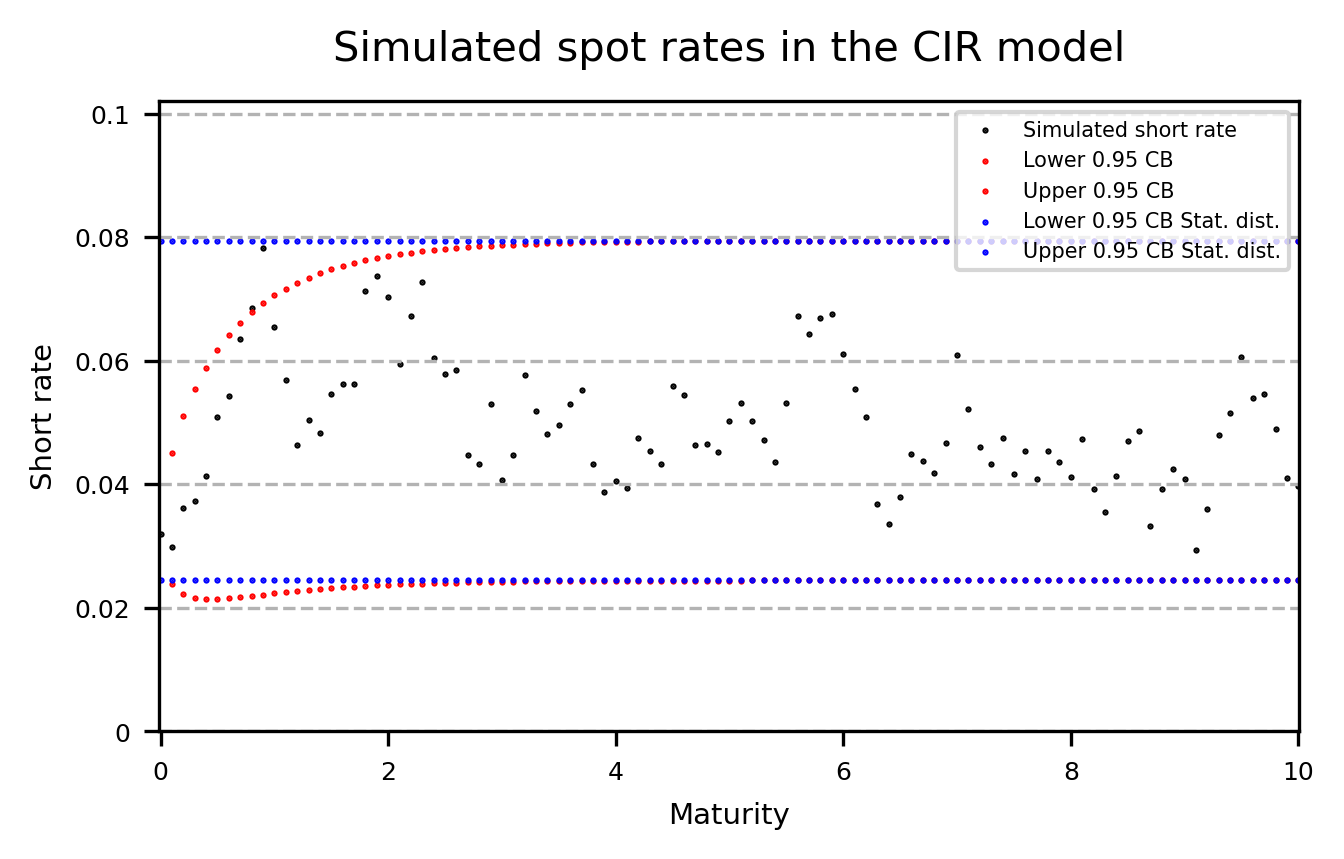

In [21]:
fig = plt.figure(constrained_layout=False,dpi=300,figsize=(5,3))
fig.suptitle(f"Simulated spot rates in the CIR model",fontsize=10)
gs = fig.add_gridspec(nrows=1,ncols=1,left=0.12,bottom=0.2,right=0.88,top=0.90,wspace=0,hspace=0)
ax = fig.add_subplot(gs[0,0])
xticks = [0,2,4,6,8,10]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks,fontsize = 6)
ax.set_xlim([xticks[0]-0.01,xticks[-1]+0.01])
plt.xlabel(f"Maturity",fontsize = 7)
yticks1 = [0,0.02,0.04,0.06,0.08,0.1]
ax.set_yticks(yticks1)
ax.set_yticklabels(yticks1,fontsize = 6)
ax.set_ylim([yticks1[0],yticks1[-1] + (yticks1[-1]-yticks1[0])*0.02])
plt.grid(axis = 'y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
ax.set_ylabel(f"Short rate",fontsize = 7)
p1 = ax.scatter(t_simul, r_simul, s = 1, color = 'black', marker = ".",label="Simulated short rate")
p2 = ax.scatter(t_simul, lb, s = 1, color = 'red', marker = ".",label=f"Lower {size_ci} CB")
p3 = ax.scatter(t_simul, ub, s = 1, color = 'red', marker = ".",label=f"Upper {size_ci} CB")
p4 = ax.scatter(t_simul, lb_sd*np.ones([M_simul+1]), s = 1, color = 'blue', marker = ".",label=f"Lower {size_ci} CB Stat. dist.")
p5 = ax.scatter(t_simul, ub_sd*np.ones([M_simul+1]), s = 1, color = 'blue', marker = ".",label=f"Upper {size_ci} CB Stat. dist.")
plots = [p1,p2,p3,p4,p5]
labels = [item.get_label() for item in plots]
ax.legend(plots,labels,loc="upper right",fontsize = 5)
# fig.savefig("C:/.pdf")
plt.show()